# Airbnb data analysis
### Questions:
>* What is the price range monthly in each region in Boston and Seattle?
>
>* What is the most vibe time in each region in Boston and Seattle?
>  
>* Can we predict the possible cost as per the corresponding holder's profiles (e.g., region, ratings, and month and day)?

# Load data

In [1]:
# set data location
data_dir = '../../Datasets/'
boston_dir = data_dir+"Boston Airbnb Open Data/"
seattle_dir = data_dir+'Seattle_Airbnb/'

In [2]:
import os
# all boston datasets and seattle datasets
bs_all,sa_all = [],[]
for root,dirs,files in os.walk(boston_dir):
    for file in files:
        bs_all.append(os.path.join(root,file))
for root,dirs,files in os.walk(seattle_dir):
    for file in files:
        sa_all.append(os.path.join(root,file))

> ## Load all datasets

In [3]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns',100)
# change number format on the display to avoid complicated scientific numbers
def format_float(x):
    if x.is_integer():
        return '{:.0f}'.format(x)  # Format integers without decimal places
    else:
        return '{:.1f}'.format(x)  # Format floats with 5 decimal places
pd.set_option('display.float_format', format_float)

In [4]:
# since both datasets contain 'reviews','listings', and 'calendar', create a dictionary key
dict_keys = ['reviews','listings','calendar']
# create dictionary of dataframes for both boston and seattle
dict_bs, dict_sa = {}, {}
for i,dict_key in enumerate(dict_keys):
    dict_bs[dict_key] = pd.read_csv(bs_all[i])
    dict_sa[dict_key] = pd.read_csv(sa_all[i])

## Wrangle data

> The data size is very large, directly merging will be too huge. Drop the non-essential columns and decrease the granuarity of the data.
>
> Focusing on the three questions shown above, NLP is not necessarily efficient in the case that the numerical ratings are given. Therefore, NLP remains to be optional for further analysis including keywords extraction and word vectorisation.

In [5]:
# save the dataframe for wrangling
ls_bs, ls_sa, cd_bs, cd_sa = dict_bs['listings'], dict_sa['listings'], dict_bs['calendar'], dict_sa['calendar']

In [6]:
# drop nans
ls_bs.dropna(how='all', axis=1, inplace=True)
ls_sa.dropna(how='all', axis=1, inplace=True)
ls_bs.dropna(how='all', axis=0, inplace=True)
ls_sa.dropna(how='all', axis=0, inplace=True)
# get the common columns for better comparision
ls_com_col = [col for col in ls_bs.columns if col in ls_sa.columns]
ls_bs, ls_sa = ls_bs[ls_com_col], ls_sa[ls_com_col]

> To address the questions in this investigation, dataframe 'reviews' and NLP are not necessarily to be included.

> check the columns and select the essential columns
> 
> * 'id', 'neighbourhood_cleansed', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',	'review_scores_checkin', 'review_scores_communication',	'review_scores_location', 'review_scores_value', 'reviews_per_month'

In [7]:
select_ls_col = ['id', 'neighbourhood_cleansed', 'price', 'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'reviews_per_month']

In [8]:
ls_bs, ls_sa = ls_bs[select_ls_col], ls_sa[select_ls_col]

> merge the listings and calendar for boston and seattle dataframes

In [9]:
# rename the price columns to avoid name clash
ls_bs.rename(columns={'price':'base_price'},inplace=True)
ls_sa.rename(columns={'price':'base_price'},inplace=True)
df_bs = ls_bs.merge(cd_bs, how='inner', left_on='id', right_on='listing_id')
df_sa = ls_sa.merge(cd_sa, how='inner', left_on='id', right_on='listing_id')
# create an extra column for both
df_bs['city'], df_sa['city'] = 'Boston', 'Seattle'
# drop id
df_bs.drop(columns='id', inplace=True)
df_sa.drop(columns='id', inplace=True)
# merge the two datasets
df = pd.concat([df_bs,df_sa], axis=0)
df.reset_index(inplace=True, drop=True)

> clean up the na values. Although the missing ratings can be filled up by regressing the ratings of each airbnb name, 20% of missing is still okay for this size of data. However, the missing values of prices are over 41%. The value can be regressed by the base_price value 

In [10]:
df.dropna(how='any', subset=['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                             'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                             'review_scores_value','reviews_per_month'], inplace=True)
df.shape

(2158975, 15)

In [11]:
# reformat base_price and price
df['base_price'] = df['base_price'].str.extract(r'(\d+\.\d+)')
df['price'] = df['price'].str.extract(r'(\d+\.\d+)')
df[['base_price','price']] = df[['base_price','price']].astype('float32')
df = df.query('base_price > 0')

> clean the price ouliers. To be more precise, the outliers are cleaned as per each city. In this case, a simple strategy ($\mu\pm\sigma$) is applied. More strategies can be discussed in further analysis.

In [12]:
indx_bs, indx_sa = df.city == 'Boston', df.city == 'Seattle'
# the bounds for boston
price_bs_low, price_bs_high = df[indx_bs].base_price.describe()['mean'] - df[indx_bs].base_price.describe()['std'],\
                              df[indx_bs].base_price.describe()['mean'] + df[indx_bs].base_price.describe()['std']
# the bounds for seattle
price_sa_low, price_sa_high = df[indx_sa].base_price.describe()['mean'] - df[indx_sa].base_price.describe()['std'],\
                              df[indx_sa].base_price.describe()['mean'] + df[indx_sa].base_price.describe()['std']

In [13]:
# remove the outliers
df.drop(df[(df.base_price<price_bs_low) & (indx_bs)].index, inplace=True)
df.drop(df[(df.base_price>price_bs_high) & (indx_bs)].index, inplace=True)
df.drop(df[(df.base_price<price_sa_low) & (indx_sa)].index, inplace=True)
df.drop(df[(df.base_price>price_sa_high) & (indx_sa)].index, inplace=True)

> now the number base_price outliers are dropped.

In [14]:
df[indx_bs].describe()

,base_price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,listing_id,price
count,786940,786940,786940,786940,786940,786940,786940,786940,786940,786940,392622
mean,140.5,92.2,9.5,9.3,9.7,9.7,9.4,9.2,2.2,7631177.0,155.8
std,58.2,8.7,0.9,1.1,0.7,0.7,0.8,1.0,2.2,4346691.1,94.9
min,58,20,2,2,2,4,2,2,0.0,5506,6
25%,88,89,9,9,10,9,9,9,0.6,4157932.2,85
50%,135,94,10,10,10,10,10,9,1.5,7693143.5,137
75%,185,98,10,10,10,10,10,10,3,11686815.8,199
max,272,100,10,10,10,10,10,10,19.1,14843050,999


In [15]:
# fill the na values in price coln using base_price
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['city_label'] = le.fit_transform(df.city)
df['city_label'] = df['city_label'].astype('int8')
from sklearn.linear_model import LinearRegression
lrm = LinearRegression()
indx_missing = df.price.isnull()
x_train, x_test, y_train, y_test = df[['base_price','city_label']][~indx_missing].values, df[['base_price','city_label']][indx_missing].values,\
                                    df.price[~indx_missing], df.price[indx_missing]
lrm.fit(x_train, y_train)
y_pred = lrm.predict(x_test)
df.price[indx_missing] = np.round(y_pred)

> There are outliers in the filled up price, however, the outliers are meant to be kept to consider the market effect.

In [16]:
df[indx_bs].describe()

,base_price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,listing_id,price,city_label
count,786940,786940,786940,786940,786940,786940,786940,786940,786940,786940,786940,786940
mean,140.5,92.2,9.5,9.3,9.7,9.7,9.4,9.2,2.2,7631177.0,157.3,0
std,58.2,8.7,0.9,1.1,0.7,0.7,0.8,1.0,2.2,4346691.1,81.6,0
min,58,20,2,2,2,4,2,2,0.0,5506,6,0
25%,88,89,9,9,10,9,9,9,0.6,4157932.2,94,0
50%,135,94,10,10,10,10,10,9,1.5,7693143.5,145,0
75%,185,98,10,10,10,10,10,10,3,11686815.8,201,0
max,272,100,10,10,10,10,10,10,19.1,14843050,999,0


In [17]:
# continue to clean and minimise the memory size
df.drop(columns=['listing_id'], inplace=True)
df[['city','neighbourhood_cleansed']]=df[['city','neighbourhood_cleansed']].astype('category')
review_int_cols = ['review_scores_rating','review_scores_accuracy','review_scores_cleanliness',
                             'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                             'review_scores_value']
df[review_int_cols] = df[review_int_cols].astype('int8')
df['reviews_per_month'] = df['reviews_per_month'].astype('float16')
# replace column 'available' with 'booked' to show how many bookings
df['booked'] = df.available.apply(lambda x: x=='f').astype('int8')
df.drop(columns='available',inplace=True)

In [18]:
# reformat date
df.date = pd.to_datetime(df.date)
# create new columns for year, month and day
df['year'] = df.date.dt.year.astype('int16')
df['month'] = df.date.dt.month.astype('int8')
df['month_name'] = df.date.dt.month_name().astype('category')
# order the months
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['month_name'] = pd.Categorical(df['month_name'], categories=month_order, ordered=True)
df['day'] = df.date.dt.day.astype('int8')
df.drop(columns='date',inplace=True)

In [19]:
df.sample(5)

,neighbourhood_cleansed,base_price,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,price,city,city_label,booked,year,month,month_name,day
1892127,First Hill,80,93,9,8,10,10,10,9,1.8,87,Seattle,1,1,2016,12,December,1
1391610,East Queen Anne,195,82,9,8,9,9,9,8,1.4,195,Seattle,1,0,2016,8,August,21
1252496,Allston,80,88,10,10,10,9,9,9,5.4,80,Boston,0,0,2017,2,February,22
827208,Fenway,140,100,10,10,10,10,10,10,1.0,157,Boston,0,1,2016,11,November,29
2372400,Broadway,59,91,9,9,10,9,10,9,7.7,63,Seattle,1,1,2016,9,September,25


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1796165 entries, 365 to 2701364
Data columns (total 18 columns):
 #   Column                       Dtype   
---  ------                       -----   
 0   neighbourhood_cleansed       category
 1   base_price                   float32 
 2   review_scores_rating         int8    
 3   review_scores_accuracy       int8    
 4   review_scores_cleanliness    int8    
 5   review_scores_checkin        int8    
 6   review_scores_communication  int8    
 7   review_scores_location       int8    
 8   review_scores_value          int8    
 9   reviews_per_month            float16 
 10  price                        float32 
 11  city                         category
 12  city_label                   int8    
 13  booked                       int8    
 14  year                         int16   
 15  month                        int8    
 16  month_name                   category
 17  day                          int8    
dtypes: category(3), float16(1

In [21]:
df.isnull().sum()

neighbourhood_cleansed         0
base_price                     0
review_scores_rating           0
review_scores_accuracy         0
review_scores_cleanliness      0
review_scores_checkin          0
review_scores_communication    0
review_scores_location         0
review_scores_value            0
reviews_per_month              0
price                          0
city                           0
city_label                     0
booked                         0
year                           0
month                          0
month_name                     0
day                            0
dtype: int64

## Analyse the data

In [22]:
import seaborn as sns
import matplotlib.pyplot as plt

> What is the price range monthly in each region in Boston and Seattle?

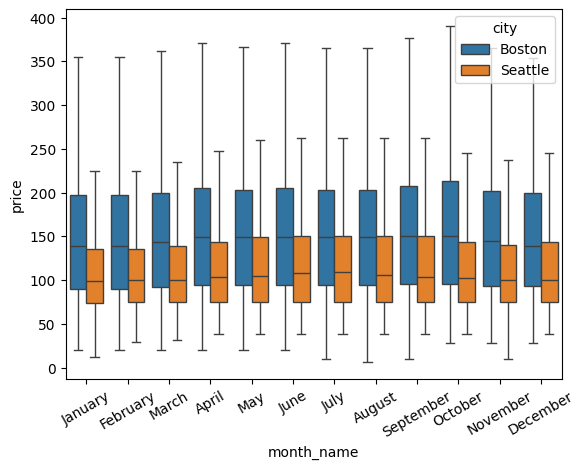

In [23]:
sns.boxplot(data=df,x='month_name',y='price',hue='city', showfliers=False)
plt.xticks(rotation=30)
plt.show()

>What is the most vibe time in each region in Boston and Seattle?

In [62]:
book_pct = df.groupby(by=['city','neighbourhood_cleansed','month_name','month']).booked.sum()/df.groupby(by=['city','neighbourhood_cleansed','month_name','month']).booked.count()*100
book_pct = book_pct.groupby(level=1).aggregate(['idxmax', 'max'])
book_pct

,idxmax,max
neighbourhood_cleansed,,
Adams,"(Seattle, Adams, July, 7)",43.3
Alki,"(Seattle, Alki, August, 8)",42.6
Allston,"(Boston, Allston, September, 9)",79.7
Arbor Heights,"(Seattle, Arbor Heights, January, 1)",38.9
Atlantic,"(Seattle, Atlantic, July, 7)",54.1
...,...,...
West Woodland,"(Seattle, West Woodland, January, 1)",49.5
Westlake,"(Seattle, Westlake, January, 1)",50.4
Whittier Heights,"(Seattle, Whittier Heights, January, 1)",51.1


In [79]:
# create a dataframe for the maximum percentage of bookings
book_pct = df.groupby(by=['city','neighbourhood_cleansed','month_name','month']).booked.sum()/df.groupby(by=['city','neighbourhood_cleansed','month_name','month']).booked.count()*100
book_pct = book_pct.groupby(level=1).aggregate(['idxmax', 'max'])
book_pct.reset_index(inplace=True)
book_pct.rename(columns = dict(zip(book_pct.columns.tolist(),['region','city_region_month','max_booking_percentage'])), inplace=True)
book_pct[['city', 'month', 'month_name']] = book_pct['city_region_month'].apply(lambda x: pd.Series([x[0],x[3],x[2]]))
book_pct.drop(columns=['city_region_month'], inplace=True)
book_pct.month_name = pd.Categorical(book_pct.month_name, categories=month_order, ordered=True)

In [80]:
# create a dataframe for sum of reviews per month
nrew = df.groupby(by=['city','neighbourhood_cleansed','month']).reviews_per_month.mean()
nrew = nrew.groupby(level=1).mean()
book_pct_nrew = book_pct.merge(nrew, how='inner', left_on='region', right_on='neighbourhood_cleansed')
book_pct_nrew

,region,max_booking_percentage,city,month,month_name,reviews_per_month
0,Adams,43.3,Seattle,7,July,2.7
1,Alki,42.6,Seattle,8,August,2.0
2,Allston,79.7,Boston,9,September,2.0
3,Arbor Heights,38.9,Seattle,1,January,1.0
4,Atlantic,54.1,Seattle,7,July,2.4
...,...,...,...,...,...,...
106,West Woodland,49.5,Seattle,1,January,2.9
107,Westlake,50.4,Seattle,1,January,2.0
108,Whittier Heights,51.1,Seattle,1,January,3.1
109,Windermere,60.2,Seattle,8,August,1.3


In [81]:
# find the most vibe region in each month for each city
max_indx = book_pct_nrew.groupby(by=['city','month']).max_booking_percentage.idxmax().values
vibe_month = book_pct_nrew.iloc[max_indx]
vibe_month

,region,max_booking_percentage,city,month,month_name,reviews_per_month
49,Leather District,100,Boston,1,January,1.9
103,West End,55.8,Boston,5,May,0.7
18,Chinatown,79.3,Boston,6,June,2.0
71,North End,79.9,Boston,9,September,2.7
51,Longwood Medical Area,84.9,Boston,10,October,7.6
23,Dunlap,62.4,Seattle,1,January,2.1
97,Sunset Hill,38.9,Seattle,2,February,2.6
45,International District,46.6,Seattle,3,March,5.7
81,Riverview,68.8,Seattle,4,April,2.2
28,Fauntleroy,45.2,Seattle,5,May,2.3


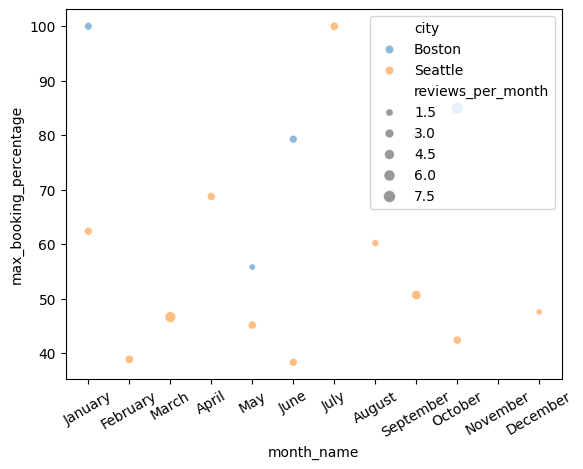

In [88]:
fig, ax = plt.subplots()
sns.scatterplot(data=vibe_month, x='month_name', y='max_booking_percentage',hue='city',
                ax=ax, size='reviews_per_month', alpha=.5, legend='auto')
plt.xticks(rotation=30)
plt.show()